### Load data

In [1]:
import pandas as pd
import numpy as np

liver_data = pd.read_csv('../NCDB_2022/liver.csv')

/var/folders/4r/chd7cdjn77j6krd2g7fstr3h0000gn/T/ipykernel_56518/1578868845.py:4: DtypeWarning: Columns (164,170,173,176,177,179,218,219,220,319,320,322,323,331,332,333,334) have mixed types. Specify dtype option on import or set low_memory=False.
  liver_data = pd.read_csv('../NCDB_2022/liver.csv')


### Filter HCC

In [2]:
valid_hist_codes = [8170, 8171, 8172, 8173, 8174, 8175, 8180]

df_hcc = liver_data[liver_data['HISTOLOGY'].isin(valid_hist_codes)]
df_hcc['HISTOLOGY'].unique()

array([8170, 8174, 8180, 8171, 8172, 8173, 8175])

In [3]:
df_hcc.shape

(287919, 340)

### Filter TACE & Systemic

In [4]:
df_hcc = df_hcc[
    df_hcc['RX_SUMM_CHEMO'].isin([2, 3]) &
    df_hcc['DX_IMMUNO_STARTED_DAYS'].notna()
]

df_hcc.shape

(2401, 340)

### Exclude same day

In [5]:
same_day = (df_hcc['DX_CHEMO_STARTED_DAYS'] - df_hcc['DX_IMMUNO_STARTED_DAYS']).abs() < 1e-6
df_hcc[same_day].shape


(532, 340)

In [6]:
df_hcc = df_hcc[df_hcc['DX_CHEMO_STARTED_DAYS'] != df_hcc['DX_IMMUNO_STARTED_DAYS']]
df_hcc.shape

(1869, 340)

### Define Sequence Group

In [7]:
df_hcc['sequence_group'] = df_hcc.apply(
    lambda row: 1 if row['DX_CHEMO_STARTED_DAYS'] < row['DX_IMMUNO_STARTED_DAYS']
    else 0,
    axis=1
)

df_hcc['sequence_group'].value_counts()


sequence_group
1    1423
0     446
Name: count, dtype: int64

### Clean Covariates

#### Combine Stage

In [8]:
df_hcc['COMBINED_STAGE_GROUP'] = df_hcc['AJCC_TNM_CLIN_STG_GRP'].combine_first(
    df_hcc['TNM_PATH_STAGE_GROUP']
)

df_hcc = df_hcc.drop(columns=[
    'AJCC_TNM_CLIN_STG_GRP', 'TNM_PATH_STAGE_GROUP'
])

In [9]:
df_hcc['COMBINED_STAGE_GROUP'].value_counts()

COMBINED_STAGE_GROUP
4B    431
3A    337
99    335
3B    235
2     221
4A    149
1B     93
88     23
1A     21
1       5
3C      4
4       2
3       1
Name: count, dtype: int64

In [10]:
df_hcc['COMBINED_STAGE_GROUP'].isna().sum()

np.int64(12)

In [11]:
df_hcc['COMBINED_STAGE_GROUP'] = df_hcc['COMBINED_STAGE_GROUP'].astype(str).replace({
    '1A': '1', '1B': '1',
    '3A': '3', '3B': '3', '3C': '3',
    '4A': '4', '4B': '4',
})

df_hcc = df_hcc[df_hcc['COMBINED_STAGE_GROUP'].isin(['1', '2', '3', '4'])]

In [12]:
df_hcc['COMBINED_STAGE_GROUP'].value_counts()

COMBINED_STAGE_GROUP
4    582
3    577
2    221
1    119
Name: count, dtype: int64

In [13]:
df_hcc.shape

(1499, 340)

#### Other covariates

In [14]:
covariates = [
    'AGE', 'SEX', 'RACE', 'SPANISH_HISPANIC_ORIGIN', #Demographics
    'INSURANCE_STATUS', 'MED_INC_QUAR_2020', #Socioeconomic
    'CDCC_TOTAL_BEST', 'HISTOLOGY', 'TUMOR_SIZE_SUMMARY_2016', 'COMBINED_STAGE_GROUP', #Clinical
    'FACILITY_TYPE_CD', 'FACILITY_LOCATION_CD', #Facility
    'YEAR_OF_DIAGNOSIS' #Temporal
]

#Recode year of diagnosis
def collapse_year(year):
    if year >= 2020:
        return '2020+'
    elif year >= 2018:
        return '2018–2019'
    else:
        return '≤2017'

df_hcc['YEAR_OF_DIAGNOSIS'] = df_hcc['YEAR_OF_DIAGNOSIS'].apply(collapse_year)


# Recode SEX
df_hcc['SEX'] = df_hcc['SEX'].replace({1: 'Male', 2: 'Female'})

# Recode RACE
df_hcc['RACE'] = df_hcc['RACE'].astype(str).map({
    '01': 'White',
    '02': 'Black',
    '04': 'Asian', '05': 'Asian', '06': 'Asian', '08': 'Asian', '10': 'Asian',
    '11': 'Asian', '12': 'Asian', '13': 'Asian', '14': 'Asian', '15': 'Asian',
    '16': 'Asian', '17': 'Asian', '96': 'Asian',
    '03': 'Pacific Islander', '20': 'Pacific Islander', '21': 'Pacific Islander',
    '22': 'Pacific Islander', '25': 'Pacific Islander', '26': 'Pacific Islander',
    '27': 'Pacific Islander', '28': 'Pacific Islander', '30': 'Pacific Islander',
    '31': 'Pacific Islander', '32': 'Pacific Islander', '97': 'Pacific Islander'
}).fillna('Other')

# Recode INSURANCE_STATUS
df_hcc['INSURANCE_STATUS'] = df_hcc['INSURANCE_STATUS'].map({
    0: 'No insurance',
    1: 'Private/Managed Care',
    2: 'Medicaid',
    3: 'Medicare',
    4: 'Other Government',
    9: 'Unknown'
}).fillna('Unknown')

# Recode area_MedianIncome2016_2020 from MED_INC_QUAR_2020
df_hcc['MEDIAN_INCOME'] = df_hcc['MED_INC_QUAR_2020'].map({
    1: '<$46,277',
    2: '$46,277-$57,856',
    3: '$57,857-$74,062',
    4: '>$74,063'
}).fillna('Unknown')

# Recode Charlson-Deyo Score
df_hcc['Charlson_Deyo_Score'] = df_hcc['CDCC_TOTAL_BEST'].map({
    0: '0',
    1: '1',
    2: '2',
    3: '3'
}).fillna('Unknown')

# Recode area_NoHighSchooldegree2016_2020
# df_hcc['NoHighSchooldegree2016_2020'] = df_hcc['NO_HSD_QUAR_2020'].map({
#     1: '>=15.3%',
#     2: '9.1%-15.2%',
#     3: '5.0%-9.0%',
#     4: '<5.0%'
# }).fillna('Unknown')

# Recode facility type
df_hcc['FACILITY_TYPE'] = df_hcc['FACILITY_TYPE_CD'].map({
    1: 'Community Cancer Program',
    2: 'Comprehensive Community Cancer Program',
    3: 'Academic/Research Program',
    4: 'Integrated Network Cancer Program'
}).fillna('Unknown')

# Recode HISTOLOGY for HCC (your definition)
hcc_hist_map = {
    8170: 'HCC, NOS',
    8171: 'Fibrolamellar HCC',
    8172: 'Scirrhous HCC',
    8173: 'Spindle cell HCC',
    8174: 'Clear cell HCC',
    8175: 'Pleomorphic HCC',
    8180: 'Mixed HCC-Cholangiocarcinoma'
}
df_hcc['HISTOLOGY'] = df_hcc['HISTOLOGY'].map(hcc_hist_map).fillna('Other')

# Recode the region values using map()
region_map = {
    1: "New England",
    2: "Middle Atlantic",
    3: "South Atlantic",
    4: "East North Central",
    5: "East South Central",
    6: "West North Central",
    7: "West South Central",
    8: "Mountain",
    9: "Pacific"
}

df_hcc['FACILITY_REGION'] = df_hcc['FACILITY_LOCATION_CD'].map(region_map).fillna('Unknown')

#Recode hispanic origin
def recode_hispanic_origin(x):
    if x == 0:
        return "Non-Hispanic"
    elif x in [1, 2, 3, 4, 5, 6, 8]:
        return "Hispanic"
    elif x == 7:
        return "Likely Hispanic"
    elif x == 9:
        return "Unknown"
    else:
        return "Unknown"

df_hcc['HISPANIC'] = df_hcc['SPANISH_HISPANIC_ORIGIN'].apply(recode_hispanic_origin)

# Recode tumor size
df_hcc['TUMOR_SIZE_SUMMARY_2016'] = pd.to_numeric(df_hcc['TUMOR_SIZE_SUMMARY_2016'], errors='coerce')
df_hcc.loc[df_hcc['TUMOR_SIZE_SUMMARY_2016'] > 300.0, 'TUMOR_SIZE_SUMMARY_2016'] = np.nan

def bin_tumor_size(x):
    if pd.isna(x):
        return 'Unknown'
    elif x == 0:
        return 'No tumor'
    elif x <= 30:
        return '≤3 cm'
    elif x <= 50:
        return '3–5 cm'
    elif x <= 100:
        return '5–10 cm'
    elif x <= 200:
        return '10–20 cm'
    else:
        return '>20 cm'
    
df_hcc['TUMOR_SIZE'] = df_hcc['TUMOR_SIZE_SUMMARY_2016'].apply(bin_tumor_size)

In [15]:
columns_to_drop = [
    'SPANISH_HISPANIC_ORIGIN',
    'MED_INC_QUAR_2020',
    'CDCC_TOTAL_BEST',
    'TUMOR_SIZE_SUMMARY_2016',
    'FACILITY_TYPE_CD',
    'FACILITY_LOCATION_CD'
]

df_hcc = df_hcc.drop(columns=columns_to_drop)

covariates = [
    'AGE', 'SEX', 'RACE', 'HISPANIC', #Demographics
    'INSURANCE_STATUS', 'MEDIAN_INCOME', #Socioeconomic
    'Charlson_Deyo_Score', 'HISTOLOGY', 'TUMOR_SIZE', 'COMBINED_STAGE_GROUP', #Clinical
    'FACILITY_TYPE', 'FACILITY_REGION', #Facility
    'YEAR_OF_DIAGNOSIS' #Temporal
]

#### Unknown value count

In [16]:
df_hcc[covariates].apply(lambda col: (col == 'Unknown').sum())

AGE                       0
SEX                       0
RACE                      0
HISPANIC                 22
INSURANCE_STATUS         23
MEDIAN_INCOME           311
Charlson_Deyo_Score       0
HISTOLOGY                 0
TUMOR_SIZE              209
COMBINED_STAGE_GROUP      0
FACILITY_TYPE            58
FACILITY_REGION          58
YEAR_OF_DIAGNOSIS         0
dtype: int64

In [17]:
#Took out facilities, tumor size, and medain income due to high unknowns
covariates = [
    'AGE', 'SEX', 'RACE', 'HISPANIC', #Demographics
    'INSURANCE_STATUS', #Socioeconomic
    'Charlson_Deyo_Score', 'HISTOLOGY', 'COMBINED_STAGE_GROUP', #Clinical
    'YEAR_OF_DIAGNOSIS' #Temporal
]

### Propensity score

In [18]:
from sklearn.linear_model import LogisticRegression

# One-hot encode categorical covariates
df_encoded = pd.get_dummies(df_hcc[covariates], drop_first=True)
X = df_encoded
y = df_hcc['sequence_group']

ps_model = LogisticRegression(max_iter=2000)
ps_model.fit(X, y)

df_hcc['ps'] = ps_model.predict_proba(X)[:, 1]


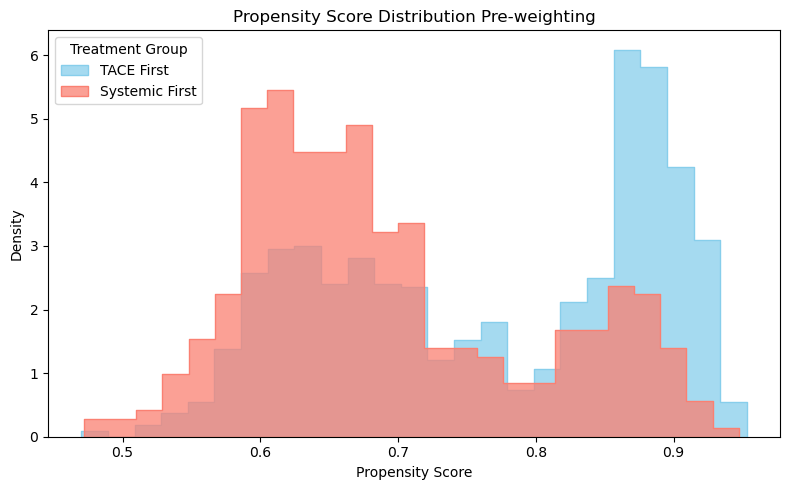

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))

sns.histplot(
    data=df_hcc[df_hcc['sequence_group'] == 1],
    x='ps', bins=25, stat='density',
    color='skyblue', label='TACE First', element='step'
)

sns.histplot(
    data=df_hcc[df_hcc['sequence_group'] == 0],
    x='ps', bins=25, stat='density',
    color='salmon', label='Systemic First', element='step'
)

plt.title("Propensity Score Distribution Pre-weighting")
plt.xlabel("Propensity Score")
plt.ylabel("Density")
plt.legend(title='Treatment Group')
plt.tight_layout()
plt.show()

## IPTW

### IPTW weights

In [20]:
df_hcc['iptw_weight'] = df_hcc.apply(
    lambda row: 1 / row['ps'] if row['sequence_group'] == 1 else 1 / (1 - row['ps']),
    axis=1
)
df_hcc['iptw_weight'].describe()

count    1499.000000
mean        1.980252
std         1.591459
min         1.049271
25%         1.156792
50%         1.452685
75%         2.022143
max        18.981555
Name: iptw_weight, dtype: float64

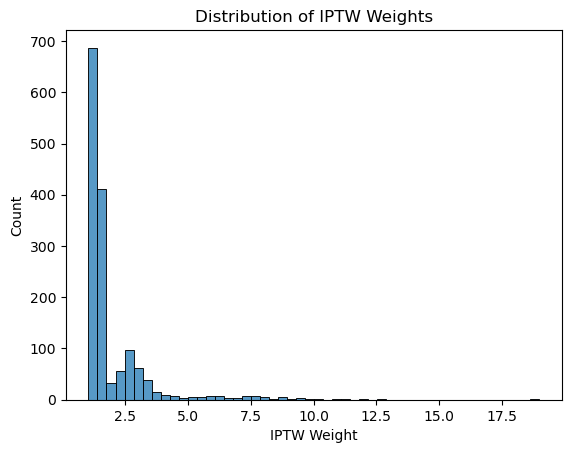

In [21]:
sns.histplot(df_hcc['iptw_weight'], bins=50)
plt.title("Distribution of IPTW Weights")
plt.xlabel("IPTW Weight")
plt.ylabel("Count")
plt.show()

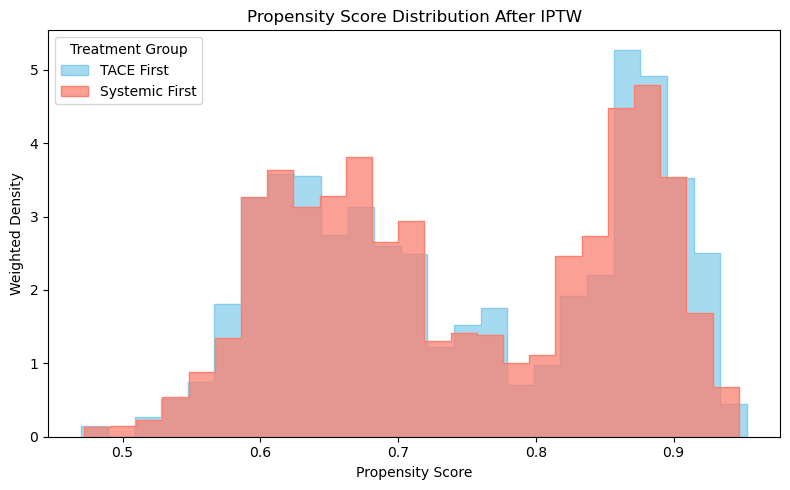

In [22]:
plt.figure(figsize=(8, 5))

sns.histplot(
    data=df_hcc[df_hcc['sequence_group'] == 1],
    x='ps', weights='iptw_weight', bins=25, stat='density',
    color='skyblue', label='TACE First', element='step'
)

sns.histplot(
    data=df_hcc[df_hcc['sequence_group'] == 0],
    x='ps', weights='iptw_weight', bins=25, stat='density',
    color='salmon', label='Systemic First', element='step'
)

plt.title("Propensity Score Distribution After IPTW")
plt.xlabel("Propensity Score")
plt.ylabel("Weighted Density")
plt.legend(title='Treatment Group')
plt.tight_layout()
plt.show()

### ITPW ASMD

In [23]:
def compute_asmd(df, covariate, treatment_col, weight_col=None):
    groups = df[treatment_col].unique()
    g1 = df[df[treatment_col] == groups[0]]
    g2 = df[df[treatment_col] == groups[1]]

    if weight_col is None:
        w1 = np.ones(len(g1))
        w2 = np.ones(len(g2))
    else:
        w1 = g1[weight_col].values
        w2 = g2[weight_col].values

    def weighted_mean_std(x, w):
        mean = np.average(x, weights=w)
        var = np.average((x - mean)**2, weights=w)
        return mean, np.sqrt(var)

    if df[covariate].dtype in [np.float64, np.int64]:
        m1, s1 = weighted_mean_std(g1[covariate], w1)
        m2, s2 = weighted_mean_std(g2[covariate], w2)
        pooled_sd = np.sqrt((s1**2 + s2**2)/2)
        asmd = abs(m1 - m2) / pooled_sd
    else:
        # Categorical variable: use dummy encoding
        dummies = pd.get_dummies(df[covariate], drop_first=False)
        asmd_list = []
        for level in dummies.columns:
            x1 = dummies.loc[g1.index, level]
            x2 = dummies.loc[g2.index, level]
            m1 = np.average(x1, weights=w1)
            m2 = np.average(x2, weights=w2)
            pooled = (m1*(1 - m1) + m2*(1 - m2)) / 2
            asmd = abs(m1 - m2) / np.sqrt(pooled) if pooled > 0 else 0
            asmd_list.append(asmd)
        asmd = np.mean(asmd_list)
    return asmd


In [24]:
asmd_unweighted = []
asmd_weighted = []

for covariate in covariates:
    try:
        a1 = compute_asmd(df_hcc, covariate, 'sequence_group', weight_col=None)
        a2 = compute_asmd(df_hcc, covariate, 'sequence_group', weight_col='iptw_weight')
    except Exception as e:
        print(f"Skipping {covariate}: {e}")
        continue
    asmd_unweighted.append(a1)
    asmd_weighted.append(a2)

asmd_df = pd.DataFrame({
    'Covariate': covariates,
    'Unweighted': asmd_unweighted,
    'IPTW': asmd_weighted
})


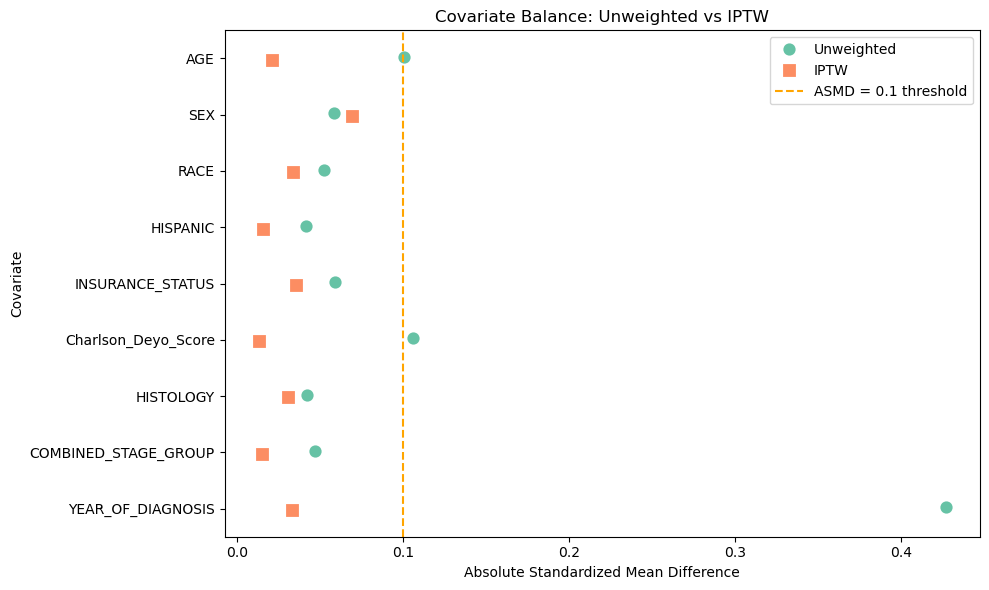

In [25]:
asmd_df_melted = asmd_df.melt(id_vars='Covariate', var_name='Method', value_name='ASMD')

plt.figure(figsize=(10, 6))
sns.pointplot(
    data=asmd_df_melted,
    x='ASMD',
    y='Covariate',
    hue='Method',
    dodge=True,  # Separate points for each method
    linestyle='none',  # Do not connect points with lines
    markers=["o", "s", "D"],  # Optional: Different markers for clarity
    palette="Set2"  # Optional: Custom color palette
)
plt.axvline(0.1, linestyle='--', color='orange', label='ASMD = 0.1 threshold')
plt.xlabel("Absolute Standardized Mean Difference")
plt.title("Covariate Balance: Unweighted vs IPTW")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

### IPTW-weighted Kaplan-Meier and Cox

#### KM

In [26]:
# Keep only valid cases
df_surv = df_hcc.copy()

# Drop missing or invalid values
df_surv = df_surv[
    (df_surv['PUF_VITAL_STATUS'].isin([0, 1])) &
    (df_surv['DX_LASTCONTACT_DEATH_MONTHS'].notna()) &
    (df_surv['DX_LASTCONTACT_DEATH_MONTHS'] != 9999.0)
].copy()

# Create survival time and event indicators
df_surv['time'] = df_surv['DX_LASTCONTACT_DEATH_MONTHS']
df_surv['event'] = df_surv['PUF_VITAL_STATUS'].apply(lambda x: 1 if x == 0 else 0)  # 1 = dead = event

# Confirm format
df_surv.shape

(1245, 343)

In [27]:
df_surv['sequence_group'].value_counts()


sequence_group
1    982
0    263
Name: count, dtype: int64

In [28]:
df_surv['group_label'] = df_surv['sequence_group'].map({0: 'Systemic First', 1: 'TACE First'})

In [29]:
from lifelines import KaplanMeierFitter

# Split into TACE-first and Systemic-first
mask_tace = df_surv['sequence_group'] == 1
mask_sys = df_surv['sequence_group'] == 0

# Initialize fitters
kmf_tace = KaplanMeierFitter()
kmf_sys = KaplanMeierFitter()

# Fit each group with weights
kmf_tace.fit(
    durations=df_surv.loc[mask_tace, 'time'],
    event_observed=df_surv.loc[mask_tace, 'event'],
    weights=df_surv.loc[mask_tace, 'iptw_weight'],
    label="TACE First"
)

kmf_sys.fit(
    durations=df_surv.loc[mask_sys, 'time'],
    event_observed=df_surv.loc[mask_sys, 'event'],
    weights=df_surv.loc[mask_sys, 'iptw_weight'],
    label="Systemic First"
)

/Users/nicolaszhang/miniconda3/envs/data_science_env/lib/python3.12/site-packages/lifelines/fitters/kaplan_meier_fitter.py:338: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  warnings.warn(
/Users/nicolaszhang/miniconda3/envs/data_science_env/lib/python3.12/site-packages/lifelines/fitters/kaplan_meier_fitter.py:338: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate

<lifelines.KaplanMeierFitter:"Systemic First", fitted with 1146.49 total observations, 402.128 right-censored observations>

#### Weighted Number at Risk

In [30]:
time_grid = np.arange(0, df_surv['time'].max(), 12)  # 0, 12, 24, ..., up to max observed time

def weighted_risk_counts(df, time_points, group_value):
    risk_counts = []
    group = df[df['sequence_group'] == group_value]
    for t in time_points:
        still_at_risk = group[group['time'] >= t]['iptw_weight'].sum()
        risk_counts.append(int(round(still_at_risk)))
    return risk_counts

tace_risk = weighted_risk_counts(df_surv, time_grid, 1)
sys_risk = weighted_risk_counts(df_surv, time_grid, 0)



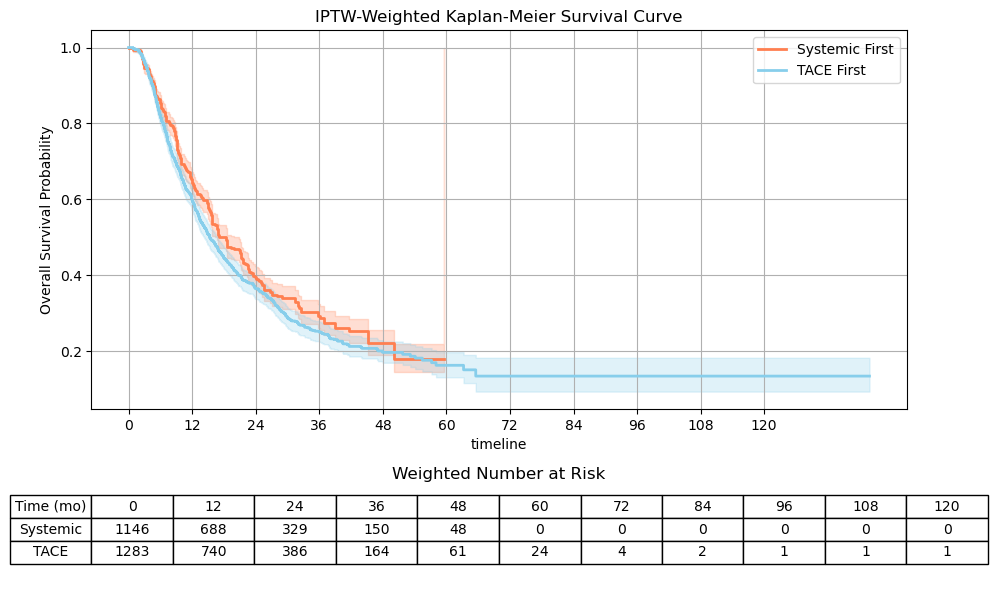

In [31]:
from matplotlib import gridspec
from matplotlib.table import Table

time_grid = np.arange(0, 121, 12)

# Build the plot
fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 0.8])

# Top: KM plot
ax_km = plt.subplot(gs[0])
kmf_sys.plot(ax=ax_km, ci_show=True, color="coral", linewidth=2)
kmf_tace.plot(ax=ax_km, ci_show=True, color="skyblue", linewidth=2)

ax_km.set_title("IPTW-Weighted Kaplan-Meier Survival Curve")
ax_km.set_ylabel("Overall Survival Probability")
ax_km.set_xticks(time_grid)  # Align x-ticks with table
ax_km.grid(True)

# Bottom: risk table
ax_table = plt.subplot(gs[1])
ax_table.axis("off")

# Table data
n_cols = len(time_grid)
table_data = [
    ["Time (mo)"] + [str(int(t)) for t in time_grid],
    ["Systemic"] + [str(n) for n in sys_risk[:n_cols]],
    ["TACE"] + [str(n) for n in tace_risk[:n_cols]]
]

# Create table
risk_table = ax_table.table(
    cellText=table_data,
    cellLoc='center',
    loc='center'
)
ax_table.text(0.5, 1, "Weighted Number at Risk", fontsize=12,
              ha='center', transform=ax_table.transAxes)

risk_table.auto_set_font_size(False)
risk_table.set_fontsize(10)
risk_table.scale(1.2, 1.2)

plt.tight_layout()
plt.show()

"Kaplan-Meier estimates were weighted using IPTW. Variance estimates were not corrected via bootstrap or Monte Carlo methods."

#### Cox

In [32]:
from lifelines import CoxPHFitter

df_cox = df_surv[['time', 'event', 'sequence_group', 'iptw_weight']].copy()

cph = CoxPHFitter()
cph.fit(df_cox, duration_col='time', event_col='event', weights_col='iptw_weight')
cph.print_summary()



/Users/nicolaszhang/miniconda3/envs/data_science_env/lib/python3.12/site-packages/lifelines/fitters/coxph_fitter.py:1356: StatisticalWarning: It appears your weights are not integers, possibly propensity or sampling scores then?
It's important to know that the naive variance estimates of the coefficients are biased. Instead a) set `robust=True` in the call to `fit`, or b) use Monte Carlo to
estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"

  warnings.warn(


<lifelines.CoxPHFitter: fitted with 2429.67 total observations, 765.376 right-censored observations>
             duration col = 'time'
                event col = 'event'
              weights col = 'iptw_weight'
      baseline estimation = breslow
   number of observations = 2429.67
number of events observed = 1664.29
   partial log-likelihood = -11850.41
         time fit was run = 2025-05-23 21:38:57 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
sequence_group  0.11      1.12      0.05            0.02            0.21                1.02                1.23

                cmp to    z    p  -log2(p)
covariate                                 
sequence_group    0.00 2.31 0.02      5.58
---
Concordance = 0.52
Partial AIC = 23702.82
log-likelihood ratio test = 5.35 on 1 df
-log2(p) of ll-ratio test = 5.59

### 3 & 5 year survival

In [33]:
def survival_with_ci(kmf, time):
    surv = kmf.predict(time)
    
    closest_idx = kmf.confidence_interval_.index.get_indexer([time], method='nearest')[0]
    ci = kmf.confidence_interval_.iloc[closest_idx]

    lower = ci.iloc[0]
    upper = ci.iloc[1]

    # sanity check for CI
    if (upper == 1.0 and lower == 1.0) or (upper == 0.0 and lower == 0.0):
        return surv, None, None  # invalid or non-estimable CI

    return surv, lower, upper

for t in [36, 60]:
    surv_sys, low_sys, high_sys = survival_with_ci(kmf_sys, t)
    surv_tace, low_tace, high_tace = survival_with_ci(kmf_tace, t)


    print(f"\nTime: {t} months")
    print(f"TACE First:     {surv_tace:.1%} ({low_tace:.1%} – {high_tace:.1%})")
    
    if low_sys is None:
        print(f"Systemic First: {surv_sys:.1%} (CI not estimable)")
    else:
        print(f"Systemic First: {surv_sys:.1%} ({low_sys:.1%} – {high_sys:.1%})")





Time: 36 months
TACE First:     25.0% (22.4% – 27.7%)
Systemic First: 29.2% (25.7% – 31.9%)

Time: 60 months
TACE First:     16.3% (13.1% – 19.7%)
Systemic First: 18.0% (CI not estimable)


### Combined Plot

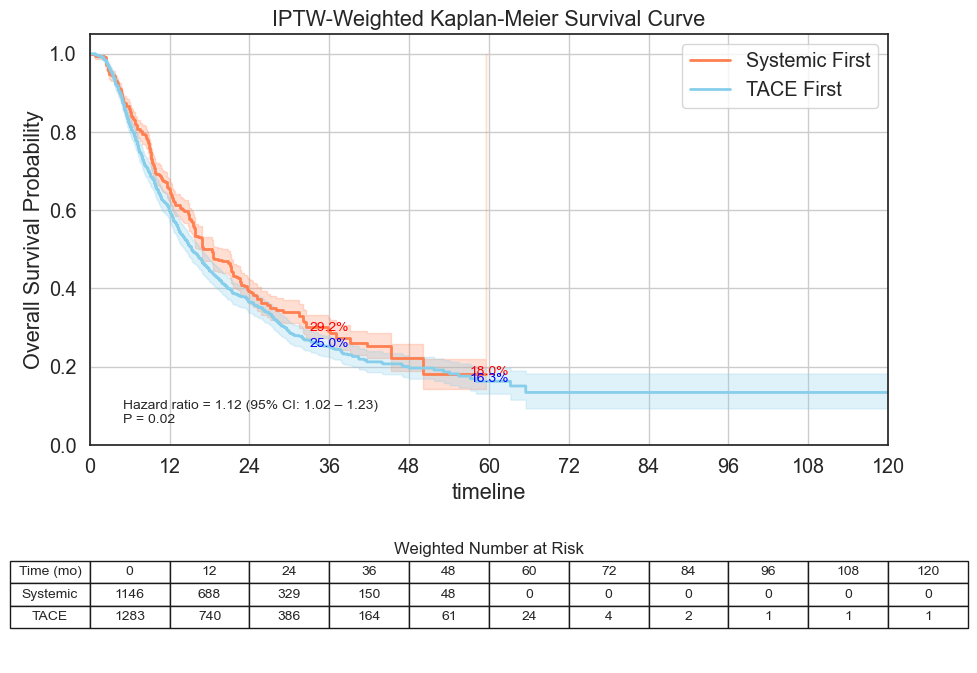

In [51]:
# 3-year and 5-year survival annotations
surv_text = {
    "Systemic First": {
        36: "29.2%",
        60: "18.0%"
    },
    "TACE First": {
        36: "25.0%",
        60: "16.3%"
    }
}

# Cox model results
hr = 1.12
ci_low = 1.02
ci_high = 1.23
p_val = 0.02

# Set up the plot
fig = plt.figure(figsize=(10, 7))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

# --- KM Curve (Top Panel) ---
ax_km = plt.subplot(gs[0])

# Simulated curves (replace with kmf.plot output in actual use)
months = np.linspace(0, 120, 121)
kmf_sys.plot(ax=ax_km, ci_show=True, color="coral", linewidth=2)
kmf_tace.plot(ax=ax_km, ci_show=True, color="skyblue", linewidth=2)

sys_surv = kmf_sys.predict(months)
tace_surv = kmf_tace.predict(months)

# Annotate survival rates at 3 and 5 years
for x in [36, 60]:
    ax_km.text(x, sys_surv[x], surv_text["Systemic First"][x], color="red", fontsize=10, ha='center')
    ax_km.text(x, tace_surv[x], surv_text["TACE First"][x], color="blue", fontsize=10, ha='center')

# Annotate Cox HR and p-value
hr_text = f"Hazard ratio = {hr:.2f} (95% CI: {ci_low:.2f} – {ci_high:.2f})\nP = {p_val:.2f}"
ax_km.text(5, 0.05, hr_text, fontsize=10, verticalalignment='bottom')

# Style the plot
ax_km.set_title("IPTW-Weighted Kaplan-Meier Survival Curve")
ax_km.set_ylabel("Overall Survival Probability")
ax_km.set_xlim(0, 120)
ax_km.set_ylim(0, 1.05)
ax_km.set_xticks(time_grid)
ax_km.grid(True)
ax_km.legend()

# --- Risk Table (Bottom Panel) ---
ax_table = plt.subplot(gs[1])
ax_table.axis("off")

# Table values
n_cols = len(time_grid)
table_data = [
    ["Time (mo)"] + [str(int(t)) for t in time_grid],
    ["Systemic"] + [str(n) for n in sys_risk[:n_cols]],
    ["TACE"] + [str(n) for n in tace_risk[:n_cols]]
]

# Render the table
risk_table = ax_table.table(
    cellText=table_data,
    cellLoc='center',
    loc='center'
)
ax_table.text(0.5, 0.8, "Weighted Number at Risk", fontsize=12,
              ha='center', transform=ax_table.transAxes)
risk_table.auto_set_font_size(False)
risk_table.set_fontsize(10)
risk_table.scale(1.2, 1.2)

plt.tight_layout()
plt.show()


## PSM

In [35]:
from psmpy import PsmPy
from psmpy.functions import cohenD
psm_df = df_surv[['sequence_group'] + covariates + ['time', 'event']].dropna()
psm_df.shape

(1245, 12)

### Preprocessing and matching

In [36]:
psm_df = psm_df.reset_index().rename(columns={'index': 'id'})
psm_df = pd.get_dummies(psm_df, drop_first=True)

psm = PsmPy(psm_df, treatment='sequence_group', indx='id', exclude=['time', 'event'])

# Calculate PS and match
psm.logistic_ps(balance=True)  # internally fits the logistic regression
psm.knn_matched(matcher='propensity_logit', replacement=False, caliper=0.2)


/Users/nicolaszhang/miniconda3/envs/data_science_env/lib/python3.12/site-packages/psmpy/psmpy.py:363: UserWarning: Some values do not have a match. These are dropped for purposes of establishing a matched dataframe, and subsequent calculations and plots (effect size). If you do not wish this to be the case please set drop_unmatched=False
  warnings.warn('Some values do not have a match. These are dropped for purposes of establishing a matched dataframe, and subsequent calculations and plots (effect size). If you do not wish this to be the case please set drop_unmatched=False')


In [37]:
df_matched = psm.df_matched
df_matched

,id,AGE,SEX_Male,RACE_Other,RACE_Pacific Islander,HISPANIC_Non-Hispanic,HISPANIC_Unknown,INSURANCE_STATUS_Medicare,INSURANCE_STATUS_No insurance,INSURANCE_STATUS_Other Government,...,HISTOLOGY_Spindle cell HCC,COMBINED_STAGE_GROUP_2,COMBINED_STAGE_GROUP_3,COMBINED_STAGE_GROUP_4,YEAR_OF_DIAGNOSIS_2020+,YEAR_OF_DIAGNOSIS_≤2017,propensity_score,propensity_logit,sequence_group,matched_ID
0,3204,75,True,True,False,True,False,True,False,False,...,False,False,False,True,True,False,0.337715,-0.673492,0,305259.0
1,4941,73,True,True,False,True,False,True,False,False,...,False,False,True,False,False,False,0.733945,1.014729,0,55042.0
2,5279,68,True,True,False,True,False,False,False,False,...,False,False,True,False,True,False,0.491891,-0.032440,0,264534.0
3,7512,77,True,True,False,True,False,True,False,False,...,False,False,True,False,True,False,0.376776,-0.503257,0,12866.0
4,7898,66,True,True,False,True,False,True,False,False,...,False,False,True,False,True,False,0.342491,-0.652214,0,89949.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520,270475,55,True,True,False,True,False,False,False,False,...,False,True,False,False,True,False,0.243553,-1.133298,1,NaN
521,224442,60,True,True,False,True,False,False,False,False,...,False,False,True,False,True,False,0.331321,-0.702217,1,NaN
522,55524,69,True,True,False,True,False,True,False,False,...,False,False,True,False,True,False,0.329806,-0.709063,1,NaN
523,163517,68,True,False,False,True,False,True,False,False,...,False,False,True,False,True,False,0.226768,-1.226653,1,NaN


### Propensity score distribution

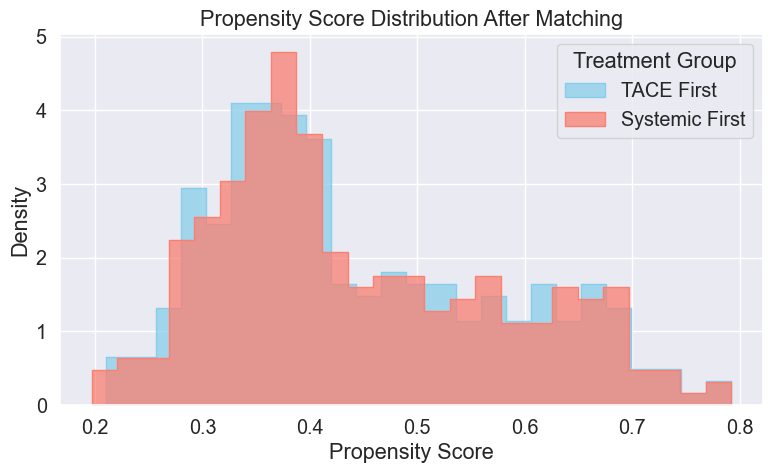

In [38]:
plt.figure(figsize=(8, 5))

sns.histplot(
    data=df_matched[df_matched['sequence_group'] == 1],
    x='propensity_score', bins=25, stat='density',
    color='skyblue', label='TACE First', element='step'
)

sns.histplot(
    data=df_matched[df_matched['sequence_group'] == 0],
    x='propensity_score', bins=25, stat='density',
    color='salmon', label='Systemic First', element='step'
)

plt.title("Propensity Score Distribution After Matching")
plt.xlabel("Propensity Score")
plt.ylabel("Density")
plt.legend(title='Treatment Group')
plt.tight_layout()
plt.show()

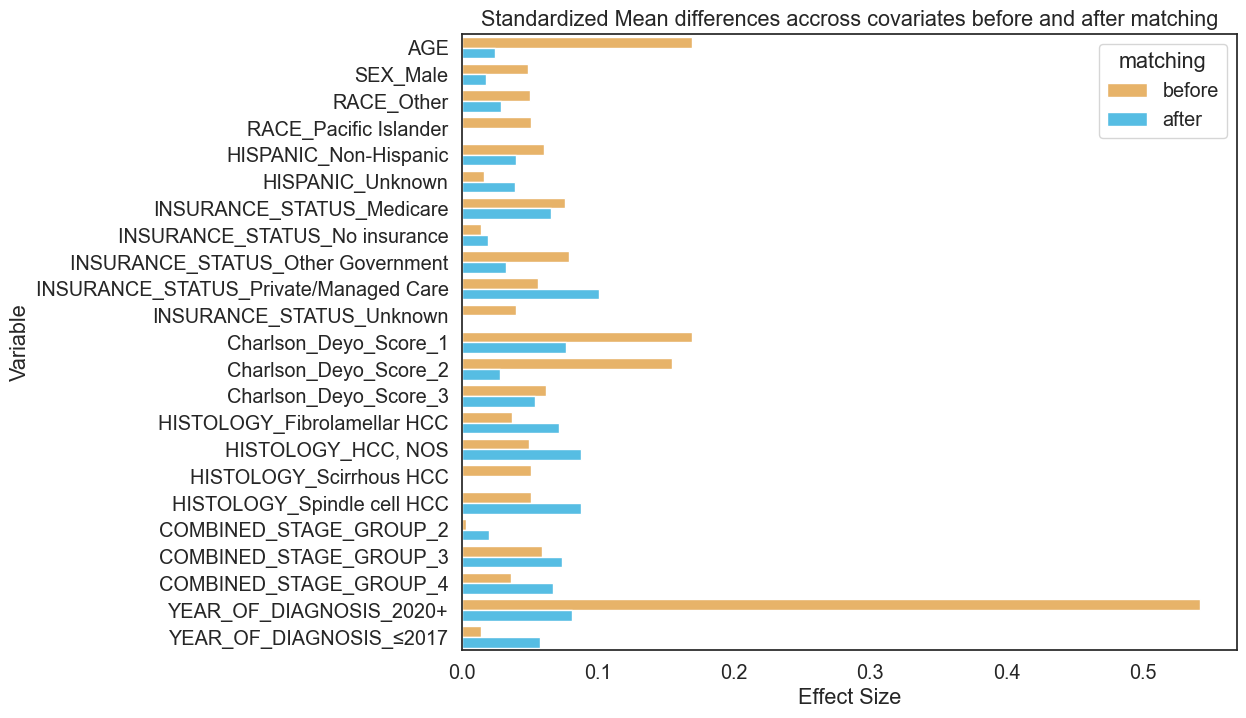

In [39]:
psm.effect_size_plot(title='Standardized Mean differences accross covariates before and after matching', before_color='#FCB754', after_color='#3EC8FB', save=False)


### PSM ASMD

In [40]:
covariate_groups = {
    'AGE': ['AGE'],  # already numeric
    'SEX': [col for col in df_matched.columns if col.startswith('SEX_')],
    'RACE': [col for col in df_matched.columns if col.startswith('RACE_')],
    'HISPANIC': [col for col in df_matched.columns if col.startswith('HISPANIC_')],
    'INSURANCE_STATUS': [col for col in df_matched.columns if col.startswith('INSURANCE_STATUS_')],
    'Charlson_Deyo_Score': [col for col in df_matched.columns if col.startswith('Charlson_Deyo_Score')],
    'HISTOLOGY': [col for col in df_matched.columns if col.startswith('HISTOLOGY_')],
    'COMBINED_STAGE_GROUP': [col for col in df_matched.columns if col.startswith('COMBINED_STAGE_GROUP')],
    'YEAR_OF_DIAGNOSIS': [col for col in df_matched.columns if col.startswith('YEAR')]
}

asmd_psm = []

for group_name, col_list in covariate_groups.items():
    d_list = []
    for col in col_list:
        try:
            d = compute_asmd(df_matched, col, 'sequence_group', weight_col=None)
            d_list.append(d)
        except Exception as e:
            print(f"Skipping {col}: {e}")
    asmd_psm.append(max(d_list) if d_list else np.nan)


In [41]:
asmd_df['PSM'] = asmd_psm
asmd_df

,Covariate,Unweighted,IPTW,PSM
0,AGE,0.100715,0.020890,0.024316
1,SEX,0.058545,0.068972,0.017909
2,RACE,0.052607,0.033546,0.029119
3,HISPANIC,0.041222,0.015805,0.039912
4,INSURANCE_STATUS,0.058896,0.035311,0.101028
5,Charlson_Deyo_Score,0.105752,0.013119,0.076712
6,HISTOLOGY,0.041918,0.030629,0.087654
7,COMBINED_STAGE_GROUP,0.047192,0.015070,0.073813
8,YEAR_OF_DIAGNOSIS,0.426771,0.033011,0.081288


In [42]:
asmd_df_melted = asmd_df.melt(id_vars='Covariate', var_name='Method', value_name='ASMD')

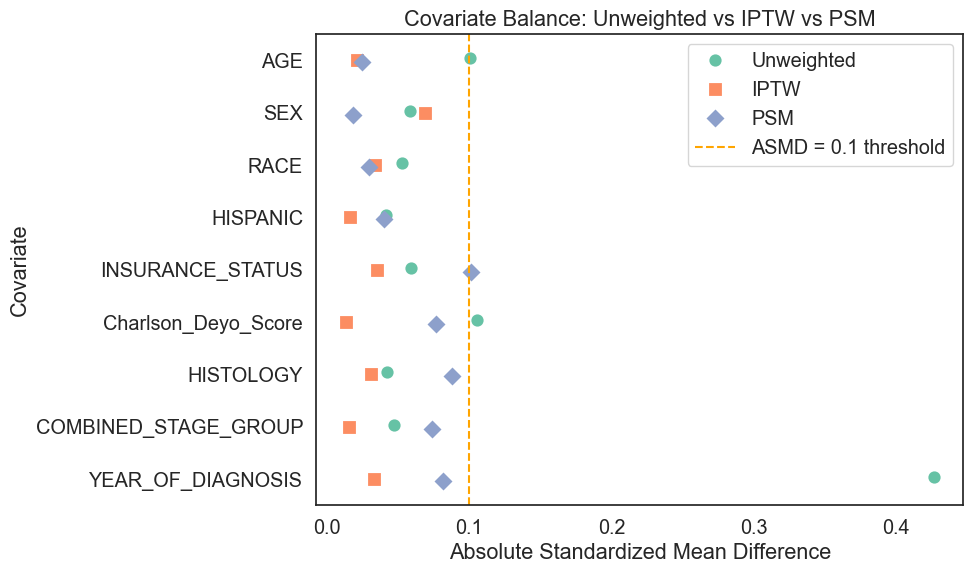

In [43]:
plt.figure(figsize=(10, 6))
sns.pointplot(
    data=asmd_df_melted,
    x='ASMD',
    y='Covariate',
    hue='Method',
    dodge=True,  # Separate points for each method
    linestyle='none',  # Do not connect points with lines
    markers=["o", "s", "D"],  # Optional: Different markers for clarity
    palette="Set2"  # Optional: Custom color palette
)
plt.axvline(0.1, linestyle='--', color='orange', label='ASMD = 0.1 threshold')
plt.xlabel("Absolute Standardized Mean Difference")
plt.title("Covariate Balance: Unweighted vs IPTW vs PSM")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

### PSM Cox

In [44]:
df_surv = df_surv.reset_index().rename(columns={'index': 'id'})
df_surv_matched = df_surv[df_surv['id'].isin(df_matched['id'])].copy()

In [45]:
df_psm_cox = df_surv_matched[['time', 'event', 'sequence_group']].copy()

cph_psm = CoxPHFitter()
cph_psm.fit(df_psm_cox, duration_col='time', event_col='event', weights_col=None)
cph_psm.print_summary()

<lifelines.CoxPHFitter: fitted with 525 total observations, 179 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 525
number of events observed = 346
   partial log-likelihood = -1937.59
         time fit was run = 2025-05-23 21:38:58 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
sequence_group  0.24      1.27      0.11            0.03            0.45                1.03                1.57

                cmp to    z    p  -log2(p)
covariate                                 
sequence_group    0.00 2.23 0.03      5.26
---
Concordance = 0.54
Partial AIC = 3877.19
log-likelihood ratio test = 4.98 on 1 df
-log2(p) of ll-ratio test = 5.28

### PSM KM

In [46]:
mask_tace_psm = df_psm_cox['sequence_group'] == 1
mask_sys_psm = df_psm_cox['sequence_group'] == 0

# Initialize fitters
kmf_tace_psm = KaplanMeierFitter()
kmf_sys_psm = KaplanMeierFitter()

# Fit each group with weights
kmf_tace_psm.fit(
    durations=df_psm_cox.loc[mask_tace_psm, 'time'],
    event_observed=df_psm_cox.loc[mask_tace_psm, 'event'],
    weights=None,
    label="TACE First"
)

kmf_sys_psm.fit(
    durations=df_psm_cox.loc[mask_sys_psm, 'time'],
    event_observed=df_psm_cox.loc[mask_sys_psm, 'event'],
    weights=None,
    label="Systemic First"
)

<lifelines.KaplanMeierFitter:"Systemic First", fitted with 263 total observations, 105 right-censored observations>

### PSM weighted number at risk

In [47]:
def risk_counts(df, time_points, group_value):
    risk_counts = []
    group = df[df['sequence_group'] == group_value]
    for t in time_points:
        still_at_risk = group[group['time'] >= t].shape[0]
        risk_counts.append(int(round(still_at_risk)))
    return risk_counts

tace_risk_psm = risk_counts(df_psm_cox, time_grid, 1)
sys_risk_psm = risk_counts(df_psm_cox, time_grid, 0)

### PSM 3&5 year survival

In [48]:
for t in [36, 60]:
    surv_sys_psm, low_sys_psm, high_sys_psm = survival_with_ci(kmf_sys_psm, t)
    surv_tace_psm, low_tace_psm, high_tace_psm = survival_with_ci(kmf_tace_psm, t)

    print(f"\nTime: {t} months")
    print(f"TACE First:     {surv_tace_psm:.1%} ({low_tace_psm:.1%} – {high_tace_psm:.1%})")
    if low_sys_psm is None or high_sys_psm is None:
        print(f"Systemic First: {surv_sys_psm:.1%} (CI not estimable)")
    else:
        print(f"Systemic First: {surv_sys_psm:.1%} ({low_sys_psm:.1%} – {high_sys_psm:.1%})")


Time: 36 months
TACE First:     22.1% (16.6% – 28.1%)
Systemic First: 32.1% (24.1% – 38.0%)

Time: 60 months
TACE First:     11.5% (3.6% – 24.4%)
Systemic First: 0.0% (CI not estimable)


### PSM combined plot

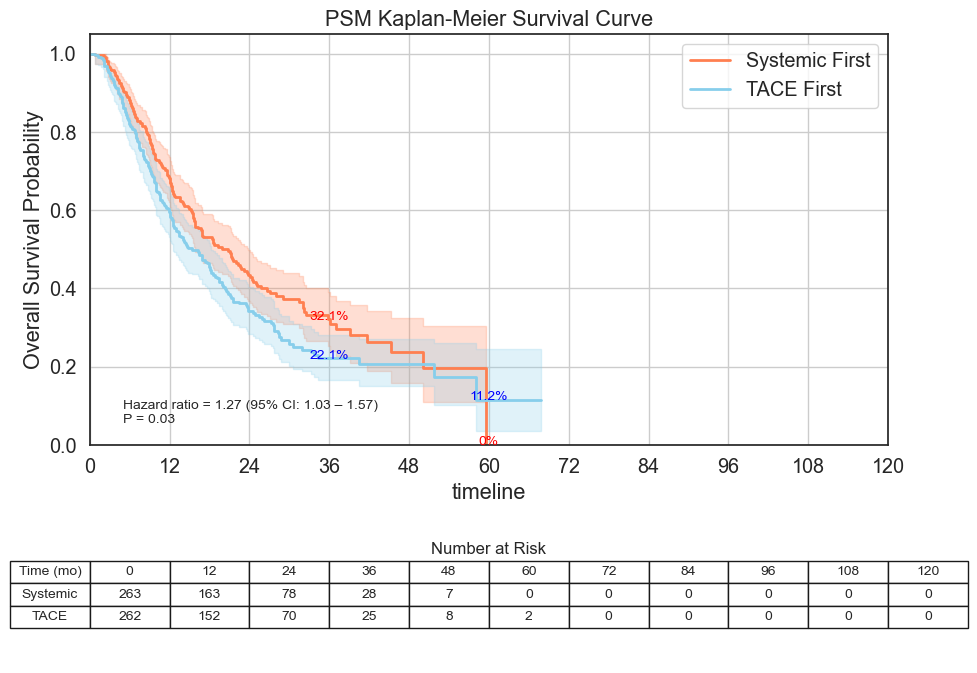

In [53]:
# 3-year and 5-year survival annotations
surv_text_psm = {
    "Systemic First": {
        36: "32.1%",
        60: "0%"
    },
    "TACE First": {
        36: "22.1%",
        60: "11.2%"
    }
}

# Cox model results
hr_psm = 1.27
ci_low_psm = 1.03
ci_high_psm = 1.57
p_val_psm = 0.03

# Set up the plot
fig = plt.figure(figsize=(10, 7))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

# --- KM Curve (Top Panel) ---
ax_km = plt.subplot(gs[0])

# Simulated curves (replace with kmf.plot output in actual use)
months = np.linspace(0, 120, 121)
kmf_sys_psm.plot(ax=ax_km, ci_show=True, color="coral", linewidth=2)
kmf_tace_psm.plot(ax=ax_km, ci_show=True, color="skyblue", linewidth=2)

sys_surv_psm = kmf_sys_psm.predict(months)
tace_surv_psm = kmf_tace_psm.predict(months)

# Annotate survival rates at 3 and 5 years
for x in [36, 60]:
    ax_km.text(x, sys_surv_psm[x], surv_text_psm["Systemic First"][x], color="red", fontsize=10, ha='center')
    ax_km.text(x, tace_surv_psm[x], surv_text_psm["TACE First"][x], color="blue", fontsize=10, ha='center')

# Annotate Cox HR and p-value
hr_text_psm = f"Hazard ratio = {hr_psm:.2f} (95% CI: {ci_low_psm:.2f} – {ci_high_psm:.2f})\nP = {p_val_psm:.2f}"
ax_km.text(5, 0.05, hr_text_psm, fontsize=10, verticalalignment='bottom')

# Style the plot
ax_km.set_title("PSM Kaplan-Meier Survival Curve")
ax_km.set_ylabel("Overall Survival Probability")
ax_km.set_xlim(0, 120)
ax_km.set_ylim(0, 1.05)
ax_km.set_xticks(time_grid)
ax_km.grid(True)
ax_km.legend()

# --- Risk Table (Bottom Panel) ---
ax_table = plt.subplot(gs[1])
ax_table.axis("off")

# Table values
n_cols = len(time_grid)
table_data = [
    ["Time (mo)"] + [str(int(t)) for t in time_grid],
    ["Systemic"] + [str(n) for n in sys_risk_psm[:n_cols]],
    ["TACE"] + [str(n) for n in tace_risk_psm[:n_cols]]
]

# Render the table
risk_table = ax_table.table(
    cellText=table_data,
    cellLoc='center',
    loc='center'
)
ax_table.text(0.5, 0.8, "Number at Risk", fontsize=12,
              ha='center', transform=ax_table.transAxes)
risk_table.auto_set_font_size(False)
risk_table.set_fontsize(10)
risk_table.scale(1.2, 1.2)

plt.tight_layout()
plt.show()


In [50]:
df_surv_matched[df_surv_matched['sequence_group'] == 0].sort_values(by='time', ascending=False).head(10)


,id,PUF_CASE_ID,PUF_FACILITY_ID,AGE,SEX,RACE,INSURANCE_STATUS,MED_INC_QUAR_00,NO_HSD_QUAR_00,UR_CD_03,...,MEDIAN_INCOME,Charlson_Deyo_Score,FACILITY_TYPE,FACILITY_REGION,HISPANIC,ps,iptw_weight,time,event,group_label
685,174004,D333f77c0-ea8f-46dd-8b5c-2ef93d497e6e,XOIUNELMQM,76,Female,Other,Medicare,4.0,2.0,1.0,...,"$57,857-$74,062",1,Academic/Research Program,South Atlantic,Non-Hispanic,0.798298,4.957816,59.53,1,Systemic First
308,73113,D9ead9cd7-1a60-42f3-b5dc-4b3527618463,JEMJLILCNX,63,Male,Other,Medicaid,NaN,NaN,6.0,...,Unknown,1,Academic/Research Program,West North Central,Non-Hispanic,0.825730,5.738239,58.84,0,Systemic First
355,89920,D2efb4d6b-3e14-4a3e-b2b0-492a8393d36a,AUUUUOWGZK,63,Male,Other,Medicare,1.0,1.0,1.0,...,"<$46,277",0,Academic/Research Program,Middle Atlantic,Hispanic,0.881318,8.425878,57.59,0,Systemic First
1061,274873,Da39417c1-8f4c-4d69-976c-8d4b737663b7,UUUEQTRPOC,71,Male,Other,Other Government,4.0,4.0,2.0,...,"$57,857-$74,062",1,Academic/Research Program,New England,Non-Hispanic,0.898128,9.816203,57.40,0,Systemic First
163,42156,Dfc9966a3-c51b-4278-979b-f70170d319e7,UVKQSKOWVI,61,Male,Other,Medicaid,4.0,2.0,2.0,...,"$57,857-$74,062",1,Community Cancer Program,Pacific,Non-Hispanic,0.835765,6.088850,54.97,0,Systemic First
1193,308467,D95844770-aab9-4466-9830-5bb2c4f6da0d,NVKRXADOIP,61,Male,Other,Private/Managed Care,3.0,2.0,4.0,...,"$46,277-$57,856",0,Integrated Network Cancer Program,South Atlantic,Non-Hispanic,0.876916,8.124529,50.14,1,Systemic First
37,8572,D8b5e2bc9-f3d1-413c-867d-fc68d9387511,AUUUUOWGZK,40,Male,Other,Private/Managed Care,2.0,1.0,1.0,...,"$46,277-$57,856",3,Academic/Research Program,Middle Atlantic,Hispanic,0.804225,5.107896,49.48,0,Systemic First
190,48455,D70cbf6f1-a5fd-44dd-8d9a-3818cd7a6a4f,OOXYPJOTXR,58,Male,Other,Medicaid,1.0,3.0,2.0,...,"<$46,277",1,Comprehensive Community Cancer Program,West North Central,Non-Hispanic,0.833283,5.998202,46.98,0,Systemic First
1163,300183,D3ec6b628-7b9f-48f5-bc84-47344f873905,QKISJQYWAB,65,Male,Other,Medicare,NaN,NaN,NaN,...,Unknown,0,Comprehensive Community Cancer Program,Pacific,Non-Hispanic,0.883483,8.582468,45.67,0,Systemic First
493,121725,D98331faf-523f-46e6-a3ff-9c7109b3800d,RSLXNONUUD,71,Male,Other,Medicare,4.0,4.0,1.0,...,">$74,063",0,Academic/Research Program,Pacific,Non-Hispanic,0.887133,8.859996,45.24,1,Systemic First
